## 2D Computation of 2-Domain Problem

In [1]:
import numpy as np
import numpy as nm
import scipy.integrate as integrate
import scipy
import pandas as pd

from matplotlib import pyplot as plt
from engy_5310_Andrew import *

In [2]:
from scipy import constants as unit
unit.kelvin = 1.0
unit.second = 1.0
unit.joule = 1.0
unit.meter = 1.0
unit.watt = unit.joule/unit.second
unit.kg = unit.kilo*unit.gram
import numpy as np

In [3]:
'''Domain'''
x_a = 0.0
x_i_l = 0.05*unit.inch
x_i_r = 0.2*unit.inch
x_b = 0.25*unit.inch

y_a = 0.1*unit.inch
y_i_l = 0.1*unit.inch
y_i_r = 0.1*unit.inch
y_b = 0.1*unit.inch

In [4]:
'''Parameters'''
k_plate = 6.096*unit.watt/unit.inch/unit.kelvin
k_coolant = 0.01524*unit.watt/unit.inch/unit.kelvin
rho_coolant = 0.0164*unit.kg/unit.inch**3
cp_coolant = 4168*unit.joule/unit.kg/unit.kelvin

s_source = 56.818*unit.watt/unit.inch**3

#x_i_l transfer
interfacial_heat_transfer_coeff = 1e15*unit.watt/unit.meter**2/unit.kelvin
interfacial_adsorption_coeff = 0

#x_i_r transfer
heat_transfer_coeff = 1000
temp_ref = unit.convert_temperature(25,'C','K')

velocity = np.zeros(3)
velocity[1] = 1*unit.milli*unit.meter/unit.second

In [20]:
'''FEM Solution'''
n_felem_plate_x = 5
n_felem_plate_y = 3
n_felem_coolant_x = n_felem_plate_x*3
n_felem_coolant_y = 3

order = 'second'
flux_order = 'first'
elem_type = 'quad8'
family = 'lagrange'

fdp_full = True
n_plot_pts_plate_x = 2*n_felem_plate_x + 1
n_plot_pts_plate_y = 40


n_plot_pts_coolant_x = 2*n_felem_coolant_x + 1
n_plot_pts_coolant_y = n_plot_pts_plate_y

In [21]:
def write_input_file(pjfnk=False):
    import pyhit
    import moosetree
    root = pyhit.load('')
    
    prblm = root.insert(-1,'Problem')
    prblm['type'] = 'FEProblem'
    prblm['coord_type'] = 'XYZ'

    mesh = root.insert(-1,'Mesh')
    
    omega1 = mesh.insert(-1,'omega1')
    omega1['type'] = 'GeneratedMeshGenerator'
    omega1['dim'] = 2
    omega1['xmin'] = x_a
    omega1['xmax'] = x_i_l
    omega1['ymin'] = 0
    omega1['ymax'] = y_i_l    
    omega1['nx'] = n_felem_plate_x
    omega1['ny'] = n_felem_plate_y
    omega1['boundary_name_prefix'] = 'omega_1'
    omega1['elem_type'] = elem_type
    
    omega2 = mesh.insert(-1,'omega2')
    omega2['type'] = 'GeneratedMeshGenerator'
    omega2['dim'] = 2
    omega2['xmin'] = x_i_l
    omega2['xmax'] = x_i_r
    omega2['ymin'] = 0
    omega2['ymax'] = y_i_r
    omega2['nx'] = n_felem_coolant_x
    omega2['ny'] = n_felem_coolant_y
    omega2['boundary_name_prefix'] = 'omega_2'
    omega2['elem_type'] = elem_type

    omega = mesh.insert(-1,'omega')
    omega['type'] = 'StitchedMeshGenerator'
    omega['inputs'] = "'omega1 omega2'"
    omega['stitch_boundaries_pairs'] = "'omega_1_right omega_2_left'"
    omega['clear_stitched_boundary_ids'] = 'true'
    
    mod1 = mesh.insert(-1,'mod1')
    mod1['type'] = 'SubdomainBoundingBoxGenerator'
    mod1['input'] = 'omega'
    mod1['block_id'] = 1
    mod1['block_name'] = 'omega_1'
    mod1['bottom_left'] = str(x_a)+' 0 0'
    mod1['top_right'] = str(x_i_l)+ ' ' + str(y_i_l) + ' 0'
    
    mod2 = mesh.insert(-1,'mod2')
    mod2['type'] = 'SubdomainBoundingBoxGenerator'
    mod2['input'] = 'mod1'
    mod2['block_id'] = 2
    mod2['block_name'] = 'omega_2'
    mod2['bottom_left'] = str(x_i_l)+' 0 0'
    mod2['top_right'] = str(x_i_r) + ' ' + str(y_i_r) + ' 0'
    
    mod3 = mesh.insert(-1,'mod3')
    mod3['type'] = 'SideSetsBetweenSubdomainsGenerator'
    mod3['input'] = 'mod2'
    mod3['primary_block'] = 'omega_1'
    mod3['paired_block'] = 'omega_2' 
    mod3['new_boundary'] = 'interface_12'
    
    mod4 = mesh.insert(-1,'mod4')
    mod4['type'] = 'SideSetsAroundSubdomainGenerator'
    mod4['input'] = 'mod3'
    mod4['block'] = 'omega_1'
    mod4['normal'] = '-1 0 0'
    mod4['new_boundary'] = 'left'
    
    mod5 = mesh.insert(-1,'mod5')
    mod5['type'] = 'SideSetsAroundSubdomainGenerator'
    mod5['input'] = 'mod4'
    mod5['block'] = 'omega_2'
    mod5['normal'] = '1 0 0'
    mod5['new_boundary'] = 'omega_2_right'

    vars = root.insert(-1,'Variables')
    
    temp_cool = vars.insert(-1,'tempPlate')
    temp_cool['block'] = 'omega_1'
    temp_cool['order'] = order
    temp_cool['family'] = family
    temp_cool['initial_condition'] = 1
    
    temp_fuel = vars.insert(-1,'tempCoolant')
    temp_fuel['block'] = 'omega_2'
    temp_fuel['order'] = order
    temp_fuel['family'] = family
    temp_fuel['initial_condition'] = 1
    
    aux_vars = root.insert(-1,'AuxVariables')
    
    heat_flux_cool = aux_vars.insert(-1,'heatFluxPlate')
    heat_flux_cool['block'] = 'omega_1'
    heat_flux_cool['order'] = flux_order
    heat_flux_cool['family'] = 'monomial_vec'
    
    heat_flux_cool_r = aux_vars.insert(-1,'heatFluxPlate_x')
    heat_flux_cool_r['block'] = 'omega_1'
    heat_flux_cool_r['order'] = flux_order
    heat_flux_cool_r['family'] = 'monomial'
    
    heat_flux_fuel = aux_vars.insert(-1,'heatFluxCoolant')
    heat_flux_fuel['block'] = 'omega_2'
    heat_flux_fuel['order'] = flux_order
    heat_flux_fuel['family'] = 'monomial_vec'
    
    heat_flux_fuel_r = aux_vars.insert(-1,'heatFluxCoolant_x')
    heat_flux_fuel_r['block'] = 'omega_2'
    heat_flux_fuel_r['order'] = flux_order
    heat_flux_fuel_r['family'] = 'monomial'

    kernels = root.insert(-1,'Kernels')
    
    conduction = kernels.insert(-1,'heat-conduction-plate')
    conduction['type'] = 'HeatConduction'
    conduction['block'] = 'omega_1'
    conduction['variable'] = 'tempPlate'
    conduction['thermCond'] = k_plate
    
    source = kernels.insert(-1,'heat-source-plate')
    source['type'] = 'HeatSource'
    source['block'] = 'omega_1'
    source['variable'] = 'tempPlate'
    source['sourceS'] = s_source
    
    conduction = kernels.insert(-1,'heat-conduction-coolant')
    conduction['type'] = 'HeatConduction'
    conduction['block'] = 'omega_2'
    conduction['variable'] = 'tempCoolant'
    conduction['thermCond'] = k_coolant
    
    convection = kernels.insert(-1,'heat-convection-coolant')
    convection['type'] = 'HeatConvection'
    convection['block'] = 'omega_2'
    convection['variable'] = 'tempCoolant'
    convection['massDensity'] = rho_coolant
    convection['heatCapacity'] = cp_coolant
    convection['velocity'] = str(velocity[0])+' '+str(velocity[1])+' '+str(velocity[2])
    
    interf_kernels = root.insert(-1,'InterfaceKernels')
    
    n_flux = interf_kernels.insert(-1,'normal-heat-flux-continuity')
    n_flux['type'] = 'InterfaceNormalFluxContinuity'
    n_flux['variable'] = 'tempPlate'
    n_flux['neighbor_var'] = 'tempCoolant'
    n_flux['boundary'] = 'interface_12'
    n_flux['thermCond'] = k_plate
    n_flux['thermCondNeighbor'] = k_coolant
    
    t_jump = interf_kernels.insert(-1,'temperature-jump')
    t_jump['type'] = 'InterfaceJump'
    t_jump['variable'] = 'tempPlate'
    t_jump['neighbor_var'] = 'tempCoolant'
    t_jump['boundary'] = 'interface_12'
    t_jump['transferCoeff'] = interfacial_heat_transfer_coeff
    t_jump['adsorptionCoeff'] = interfacial_adsorption_coeff
    t_jump['thermCondCoeff'] = k_plate

    aux_kernels = root.insert(-1,'AuxKernels')
    
    heat_flux = aux_kernels.insert(-1,'heat-flux-plate')
    heat_flux['type'] = 'HeatFlux'
    heat_flux['block'] = 'omega_1'
    heat_flux['field'] = 'tempPlate'
    heat_flux['thCondCoeff'] = k_plate
    heat_flux['variable'] = 'heatFluxPlate'
    heat_flux['execute_on'] = 'timestep_end'
    
    heat_flux_r = aux_kernels.insert(-1,'heat-flux-plate-x')
    heat_flux_r['type'] = 'VectorVariableComponentAux'
    heat_flux_r['block'] = 'omega_1'
    heat_flux_r['vector_variable'] = 'heatFluxPlate'
    heat_flux_r['component'] = 'x'
    heat_flux_r['variable'] = 'heatFluxPlate_x'
    heat_flux_r['execute_on'] = 'timestep_end'
    
    heat_flux = aux_kernels.insert(-1,'heat-flux-coolant')
    heat_flux['type'] = 'HeatFlux'
    heat_flux['block'] = 'omega_2'
    heat_flux['field'] = 'tempCoolant'
    heat_flux['thCondCoeff'] = k_coolant
    heat_flux['variable'] = 'heatFluxCoolant'
    heat_flux['execute_on'] = 'timestep_end'
    
    heat_flux_r = aux_kernels.insert(-1,'heat-flux-coolant-x')
    heat_flux_r['type'] = 'VectorVariableComponentAux'
    heat_flux_r['block'] = 'omega_2'
    heat_flux_r['vector_variable'] = 'heatFluxCoolant'
    heat_flux_r['component'] = 'x'
    heat_flux_r['variable'] = 'heatFluxCoolant_x'
    heat_flux_r['execute_on'] = 'timestep_end'
    
    bcs = root.insert(-1,'BCs')
    
    cl = bcs.insert(-1,'center-line')
    cl['type'] = 'NeumannBC'
    cl['variable'] = 'tempPlate'
    cl['boundary'] = 'left'
    cl['value'] = 0 
    
    ro = bcs.insert(-1,'x_i_r')
    ro['type'] = 'NormalHeatFluxBC'
    ro['variable'] = 'tempCoolant'
    ro['boundary'] = 'omega_2_right'
    ro['refTempFunc'] = 'refTempFunc'
    ro['transferCoeff'] = heat_transfer_coeff
    
    functions = root.insert(-1,'Functions')
    
    ref_temp_func = functions.insert(-1, 'refTempFunc')
    ref_temp_func['type'] = 'ParsedFunction'
    ref_temp_func['value'] = 'temp_ref'
    ref_temp_func['vars'] = 'temp_ref'
    ref_temp_func['vals'] = str(temp_ref)
    
    if pjfnk:
        exe = root.insert(-1,'Executioner')
        exe['type'] = 'Steady'
        exe['solve_type']  = 'PJFNK'
        exe['petsc_options_iname']  = '-pc_type -pc_hypre_type'
        exe['petsc_options_value']  = 'hypre boomeramg'
        exe['l_max_its']  = 20
        exe['l_tol']  = 1e-5
        exe['nl_max_its']  = 15
        exe['nl_rel_tol']  = 1e-8
        exe['nl_abs_tol']  = 1e-8
    elif fdp_full:
        pre = root.insert(-1, 'Preconditioning')
        pre['active'] = 'fdp-newt-full'
        
        fdp = pre.insert(-1, 'fdp-newt-full')
        fdp['type'] = 'FDP'
        fdp['full'] = 'true'
        fdp['solve_type'] = 'NEWTON'
        fdp['petsc_options_iname'] = ""'-pc_type -mat_fd_coloring_err -mat_fd_type'""
        fdp['petsc_options_value'] = ""'lu  1e-8          ds'""
        
        exe = root.insert(-1,'Executioner')
        exe['type'] = 'Steady'

    vp = root.insert(-1,'VectorPostprocessors')
    
    for y_pt in np.linspace(0,y_a,n_plot_pts_plate_y):
    
        omega_1 = vp.insert(-1,'omega_1_'+str(y_pt))
        #omega_1 = vp.insert(-1,'omega_1')
        omega_1['type'] = 'LineValueSampler'
        omega_1['execute_on'] = 'timestep_end final'
        omega_1['variable'] = 'tempPlate heatFluxPlate_x'  
        omega_1['start_point'] = str(x_a)+' ' + str(y_pt) +' 0'
        omega_1['end_point'] = str(x_i_l*0.995)+ ' ' + str(y_pt) +' 0'
        omega_1['num_points'] = n_plot_pts_plate_x
        omega_1['sort_by'] = 'id'
    
    
    for y_pt in np.linspace(0,y_a,n_plot_pts_coolant_y):
        omega_2 = vp.insert(-1,'omega_2_'+str(y_pt))
        omega_2['type'] = 'LineValueSampler'
        omega_2['execute_on'] = 'timestep_end final'
        omega_2['variable'] = 'tempCoolant heatFluxCoolant_x'  
        omega_2['start_point'] = str(x_i_l*1.005)+' ' + str(y_pt) +' 0'
        omega_2['end_point'] = str(x_i_r)+' ' + str(y_pt) +' 0'
        omega_2['num_points'] = n_plot_pts_coolant_x
        omega_2['sort_by'] = 'id' 
    
    """omega_1 = vp.insert(-1,'omega_1')
    omega_1['execute_on'] = 'timestep_end final'
    omega_1['variable'] = 'tempPlate heatFluxPlate_x'  
    omega_1['sort_by'] = 'id'
    
    omega_2 = vp.insert(-1,'omega_2')
    omega_2['execute_on'] = 'timestep_end final'
    omega_2['variable'] = 'tempCoolant heatFluxCoolant_x'  
    omega_2['sort_by'] = 'id' """

    out = root.insert(-1,'Outputs')
    out['console'] = 'true'
    """out['exodus'] = 'true'"""
    csv = out.insert(-1,'csv')
    csv['type'] = 'CSV'
    csv['file_base'] = 'output'
    csv['execute_on'] = 'final'
    
    """exodus = out.insert(-1,'other')
    exodus['type'] = 'Exodus'"""
    
    debug = root.insert(-1,'Debug')
    debug['show_var_residual_norms'] = 'true'

    pyhit.write('input.hit', root)

In [22]:
'''Input file'''
write_input_file()
!cat input.hit

[Problem]
  type = FEProblem
  coord_type = XYZ
[]
[Mesh]
  [omega1]
    type = GeneratedMeshGenerator
    dim = 2
    xmin = 0.0
    xmax = 0.00127
    ymin = 0
    ymax = 0.00254
    nx = 5
    ny = 3
    boundary_name_prefix = omega_1
    elem_type = quad8
  []
  [omega2]
    type = GeneratedMeshGenerator
    dim = 2
    xmin = 0.00127
    xmax = 0.00508
    ymin = 0
    ymax = 0.00254
    nx = 15
    ny = 3
    boundary_name_prefix = omega_2
    elem_type = quad8
  []
  [omega]
    type = StitchedMeshGenerator
    inputs = 'omega1 omega2'
    stitch_boundaries_pairs = 'omega_1_right omega_2_left'
    clear_stitched_boundary_ids = true
  []
  [mod1]
    type = SubdomainBoundingBoxGenerator
    input = omega
    block_id = 1
    block_name = omega_1
    bottom_left = '0.0 0 0'
    top_right = '0.00127 0.00254 0'
  []
  [mod2]
    type = SubdomainBoundingBoxGenerator
    input = mod1
    block_id = 2
    block_name = omega_2
    bottom_left = '0.00127 0 0'
    top_right = '0.00508 0.0

In [23]:
'''Delete any previous *.csv files'''
!rm output_omega_*.csv

In [24]:
'''Run Engy5310P1 MOOSE App'''

!./heated_plate-opt -i input.hit


In ReplicatedMesh::stitch_meshes:
This mesh has 7 nodes on boundary 1.
Other mesh has 7 nodes on boundary 3.
Minimum edge length on both surfaces is 0.000254.
In ReplicatedMesh::stitch_meshes:
Found 7 matching nodes.

Framework Information:
MOOSE Version:           git commit b98ea2c450 on 2021-09-23
LibMesh Version:         
PETSc Version:           3.15.1
SLEPc Version:           3.15.1
Current Time:            Mon Dec 27 15:15:14 2021
Executable Timestamp:    Mon Dec 27 10:58:19 2021

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          2
  Spatial Dimension:       2
  Nodes:                   227
  Elems:                   60
  Num Subdomains:          2

Nonlinear System:
  Num DOFs:                234
  Num Local DOFs:          234
  Variables:               "tempPlate" "tempCoolant" 
  Finite Element Types:    "LAGRANGE" "LAGRANGE" 
  Approximation Orders:    "SECOND" "SECOND" 

Auxiliary

In [25]:
def stitch_csv():
    import os
    import pandas as pd
    
    filenames = os.listdir(os.getcwd())
    csv_list = []
    df_list = []
    
    #Identify all .csv files
    for file in filenames:
        if file.split(".")[-1] == "csv":
            csv_list.append(file)
            
    csv_list.sort()
    num_domains = 1
    
    #Determine number of domains
    for csv in csv_list:
        if int(csv.split("_")[2]) > num_domains:
            num_domains = int(csv.split("_")[2])
            
    #Add each csv to a domain-specific dataframe
    for domain in range(num_domains):
        df_master = pd.DataFrame()
        for csv in csv_list:
            if int(csv.split("_")[2]) -1 == domain:

                df_master = df_master.append(pd.read_csv(csv),ignore_index=True)
        df_list.append(df_master)
        #df_master.to_csv("output_omega_"+str(domain+1)+"_.csv")
        
    #Remove all csv files in directory
    !rm output_omega_*.csv
    
    #Output domain-stitched csvs
    for count,df in enumerate(df_list):
        df.to_csv("output_omega_"+str(count+1)+"_.csv")

            
stitch_csv()

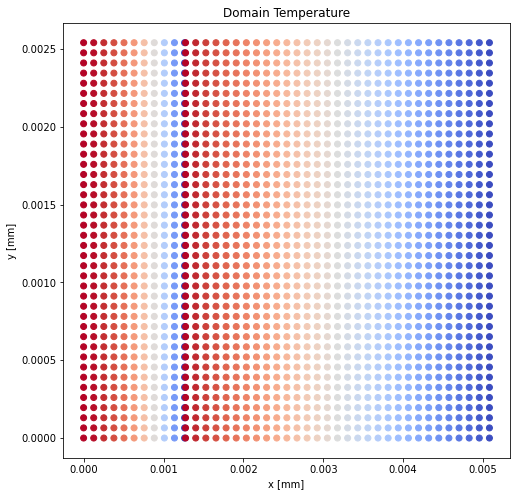

In [26]:
'''Show FEM Solution'''

import pandas as pd
df1 = pd.read_csv('output_omega_1_.csv')
df2 = pd.read_csv('output_omega_2_.csv')
save_name = "2Domain.png"
    
max_temp_list = []
max_temp_list.append(max(df1['tempPlate']))
max_temp_list.append(max(df2['tempCoolant']))
max_temp = max(max_temp_list)

fig = plt.figure(figsize=(8,8))
plt.scatter(df1['x'],df1['y'], c=df1['tempPlate']/max_temp,cmap=plt.get_cmap('coolwarm'))
plt.scatter(df2['x'],df2['y'], c=df2['tempCoolant']/max_temp,cmap=plt.get_cmap('coolwarm'))
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")
plt.title("Domain Temperature")
plt.show()